In [187]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from glob import glob 
# import seaborn as sns
sns.set_style(None)
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

In [236]:
#Reading meta-data files
unis = pd.read_csv('../data/IPEDS/hd2020.csv',encoding='cp1252')

rankings = pd.read_excel('../data/US Higher Education_ Value vs. Vulnerability.xlsx', skiprows=5,\
                         usecols=['Institution Name', 'Full Time Enrollment', 'Ranking List', 'Rank'])

## Preprocessing meta-data files
### Updating names to match in rankings  
unis.loc[unis['IALIAS']=='Virginia Tech', 'INSTNM'] = 'Virginia Tech'
unis.loc[unis['INSTNM']=='University of Illinois Urbana-Champaign', 'INSTNM'] = 'University of Illinois at Urbana-Champaign'
unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='MD'), 'INSTNM'] = "St. John's College - MD"
unis.loc[(unis['INSTNM']=="St. John's College") & (unis['STABBR']=='NM'), 'INSTNM'] = "St. John's College - NM"
unis.loc[unis['INSTNM']=="William & Mary", 'INSTNM'] = "College of William and Mary"
unis.loc[(unis['INSTNM']=="Brigham Young University") & (unis['CITY']=='Provo'), 'INSTNM'] = "Brigham Young University-Provo"
unis.loc[(unis['INSTNM']=="The University of the South") & (unis['CITY']=='Sewanee'), 'INSTNM'] = "Sewanee - The University of the South"

### Labeling 
unis = unis[unis['C18BASIC'].apply(lambda x: x in [15, 16, 17, 21, 22])]
unis['Y']  = unis['C18BASIC'].apply(lambda x: 'liberal_arts' if x in [21, 22] else 'research')

# Making sure all institutes are captured in ranking
# TODO: Come back to include all unis, not just top 100

rankings = rankings[rankings['Rank']<=100] 
merged = pd.merge(unis, rankings, left_on='INSTNM', right_on='Institution Name')

# Remove duplicates
merged = merged.set_index('UNITID')
merged = merged.groupby(merged.index).first()

# Making sure the standard names worked
assert(len(set(rankings['Institution Name']).difference(merged['INSTNM']))==0)

In [120]:
results = pd.DataFrame()

fnames = glob('../data/IPEDS/*_A/*_rv.csv')+glob('../data/IPEDS/*_a.csv')
for fname in fnames:
    year = int(fname.split('/')[-1].split('_')[0][1:])

    # Reading institute level statistics
    data = pd.read_csv(fname)

    if ('CTOTALT' in data.columns)==False:
        print(fname)
        continue
    
    ## Filtering undergraduate degrees
    data = data[data['AWLEVEL']==5]
    
    ## Coarser Major Categories 
    data['CIPCODE_CAT'] = data['CIPCODE'].astype(int)
    
    ## Count Coarse Major Catgeory Completions
    total_cip_cat = data.groupby(['UNITID','CIPCODE_CAT']).apply(lambda x: x['CTOTALT'].sum()).reset_index()
    
    total_cip_cat['year'] = year
    
    results = pd.concat([results, total_cip_cat])

../data/IPEDS/C2007_A/c2007_a_rv.csv
../data/IPEDS/C2004_A/c2004_a_rv.csv
../data/IPEDS/C2005_A/c2005_a_rv.csv
../data/IPEDS/C2006_A/c2006_a_rv.csv


/Users/fahadsultan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


../data/IPEDS/c2000_a.csv
../data/IPEDS/c2002_a.csv
../data/IPEDS/c2003_a.csv
../data/IPEDS/c2001_a.csv


In [127]:
results = results.fillna(0)

# Average over all years
means = results.groupby(['UNITID', 'CIPCODE_CAT']).apply(lambda x: pd.Series({'mean':x[0].mean(), 'sem':x[0].sem()})).reset_index()
means = means.fillna(0)

# Pivot so each row is institute, each column is a major
pivoted = pd.pivot(means, index='UNITID', columns='CIPCODE_CAT', values='mean').fillna(0)
pivoted = pivoted.drop(columns=[95])

# Convert counts to ratios
cats = top100LA.columns
pivoted = pivoted.apply(lambda x: round(100*(x[cats[:-1]]/x[cats[-1]]), 2), axis=1)


merged = merged.sort_values('Rank')
top100LA = pivoted.loc[merged.loc[merged['Y']=='liberal_arts', 'UNITID']]
top100RU = pivoted.loc[merged.loc[merged['Y']=='research', 'UNITID']]


top100LA.index = merged.loc[top100LA.index, 'INSTNM'].values

cipcode_descs = pd.read_csv('../data/cipcode_cat.csv', index_col=0)


top100LA.columns = cipcode_descs.loc[top100LA.columns, 'desc']
majors_ranked = top100LA.mean().sort_values(ascending=False).index


In [342]:
# Drop columns
cols_to_drop = top100LA.columns[top100LA.sum()==0]
top100LA = top100LA.drop(columns=cols_to_drop)

In [345]:
# Departwise, top colleges

top100LA.apply(lambda x: x.index[x.argsort()[::-1]]).to_csv('../out/dept_wise_ranking.csv', index=False)
top100LA.apply(lambda x: x.index[x.argmax()]).sort_values()

In [380]:
top100LA[:20]

desc,"AGRICULTURE, AGRICULTURE OPERATIONS, AND RELATED SCIENCES.",NATURAL RESOURCES AND CONSERVATION.,ARCHITECTURE AND RELATED SERVICES.,"AREA, ETHNIC, CULTURAL, AND GENDER STUDIES.","COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS.",COMMUNICATIONS TECHNOLOGIES/TECHNICIANS AND SUPPORT SERVICES.,COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES.,EDUCATION.,ENGINEERING.,ENGINEERING TECHNOLOGIES/TECHNICIANS.,...,PHYSICAL SCIENCES.,PSYCHOLOGY.,SECURITY AND PROTECTIVE SERVICES.,PUBLIC ADMINISTRATION AND SOCIAL SERVICE PROFESSIONS.,SOCIAL SCIENCES.,VISUAL AND PERFORMING ARTS.,HEALTH PROFESSIONS AND RELATED CLINICAL SCIENCES.,"BUSINESS, MANAGEMENT, MARKETING, AND RELATED SUPPORT SERVICES.",HISTORY,Rank
Williams College,0.0,1.17,0.00,3.83,0.00,0.0,3.65,0.00,0.00,0.00,...,8.40,7.82,0.0,0.00,24.53,7.59,0.00,0.00,7.74,1
Amherst College,0.0,2.73,0.48,6.23,0.00,0.0,3.64,0.00,0.00,0.00,...,5.54,7.85,0.0,0.00,23.23,6.13,0.00,0.00,6.08,2
Wellesley College,0.0,1.90,1.23,8.61,0.00,0.0,4.88,1.07,0.00,0.00,...,4.68,8.11,0.0,0.00,25.78,6.89,0.00,0.00,2.75,3
Swarthmore College,0.0,0.58,0.00,1.92,0.00,0.0,7.06,3.73,5.01,0.00,...,4.17,6.24,0.0,0.05,25.67,6.52,0.00,0.00,4.12,4
Pomona College,0.0,4.36,0.00,3.99,3.37,0.0,4.98,0.00,0.17,0.00,...,7.41,6.58,0.0,3.12,22.49,3.94,0.00,0.00,3.10,5
Bowdoin College,0.0,4.86,0.00,6.38,0.00,0.0,2.78,1.67,0.00,0.00,...,6.17,4.15,0.0,0.00,29.89,5.56,0.00,0.00,5.39,6
Claremont McKenna College,0.0,2.64,0.00,1.11,1.11,0.0,2.24,0.00,1.18,1.15,...,1.60,8.34,0.0,0.10,42.65,1.19,0.00,7.10,3.35,7
Carleton College,0.0,2.47,0.00,3.87,0.00,0.0,7.33,0.00,0.00,0.00,...,13.18,6.90,0.0,0.00,20.40,9.47,0.00,0.00,5.16,8
Middlebury College,0.0,5.90,1.61,6.93,0.00,0.0,2.95,0.21,0.00,0.00,...,4.30,5.06,0.0,0.00,30.30,7.92,0.00,0.00,3.74,9
Washington and Lee University,0.0,1.13,0.00,0.35,5.09,0.0,1.83,0.00,2.28,0.00,...,3.56,3.60,0.0,0.00,21.75,4.39,0.00,21.78,5.52,10


In [372]:
top100LA['Rank'] = range(1, len(top100LA)+1)

In [377]:
top100LA.corr()['Rank'].sort_values()

desc
SOCIAL SCIENCES.                                                 -0.484097
MATHEMATICS AND STATISTICS.                                      -0.458265
AREA, ETHNIC, CULTURAL, AND GENDER STUDIES.                      -0.408020
COMPUTER AND INFORMATION SCIENCES AND SUPPORT SERVICES.          -0.284286
PHYSICAL SCIENCES.                                               -0.249475
FOREIGN LANGUAGES, LITERATURES, AND LINGUISTICS.                 -0.220457
HISTORY                                                          -0.207988
LEGAL PROFESSIONS AND STUDIES.                                   -0.200087
PHILOSOPHY AND RELIGIOUS STUDIES.                                -0.188705
ARCHITECTURE AND RELATED SERVICES.                               -0.131219
ENGINEERING.                                                     -0.111574
NATURAL RESOURCES AND CONSERVATION.                              -0.047613
ENGINEERING TECHNOLOGIES/TECHNICIANS.                            -0.029955
FAMILY AND CONSUMER 

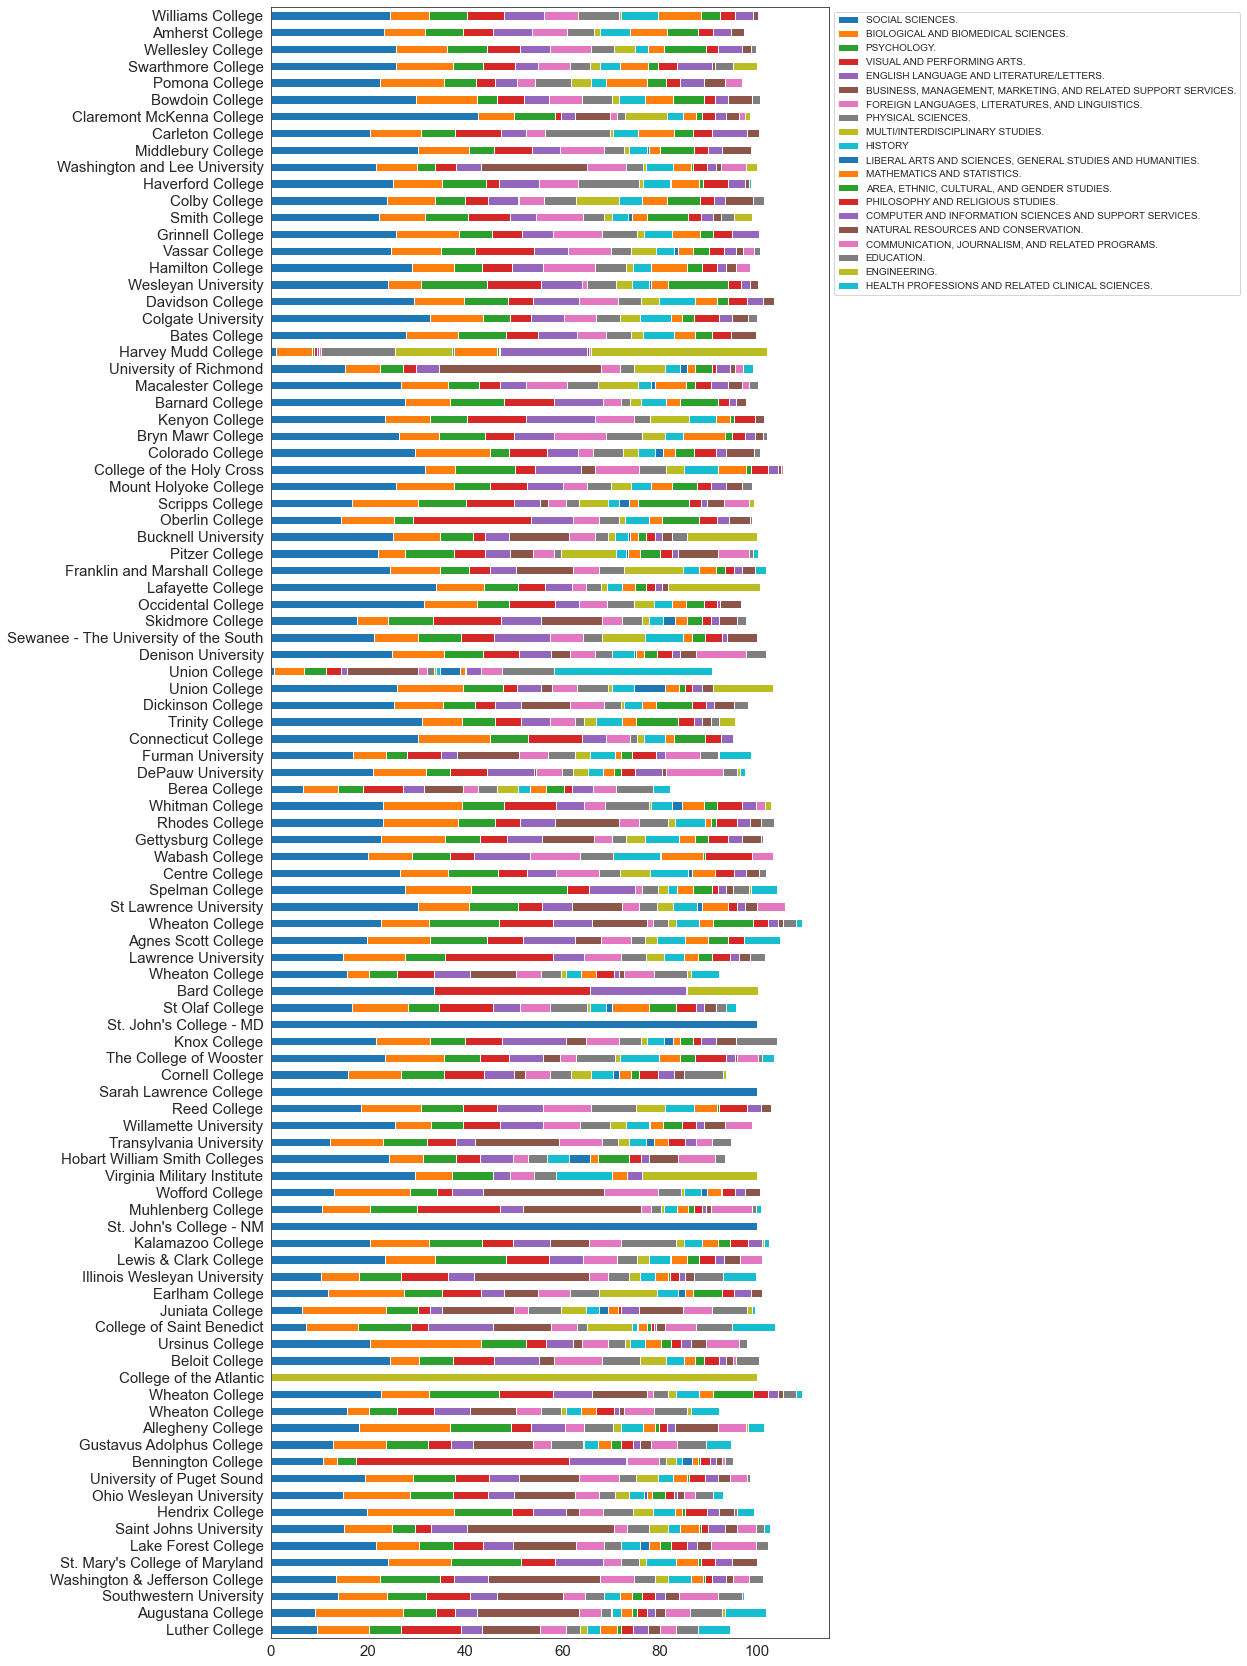

In [299]:
# Plotting

top100LA[majors_ranked[:20]][::-1].plot(kind='barh', stacked=True, figsize=(10, 30), fontsize=15)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [240]:
data = pd.read_csv('Data_5-30-2022.csv')
data.index = data['Institution Name']

data2020 = data[[col for col in data.columns if '2020' in col]]

data2020.columns = [ col.replace("Grand total (C2020_A ", "")\
                        .replace("  Bachelor's degree)",  "")\
                        .replace(" First major  ",        "")  for col in data2020.columns]

#normalize by total graduates
data2020 = data2020.apply(lambda x: round((x/x['Grand total'])*100, 2),axis=1)

majors = data2020.columns

rankings = pd.read_excel('US Higher Education_ Value vs. Vulnerability.xlsx', skiprows=5)
rankings = rankings[rankings["Ranking List"]=="USN National College Ranking"]
rankings = rankings[["Institution Name", "Rank"]]

pearsons = []
spearmans = []

for i, major in enumerate(majors): 

    cs = [col for col in data2020.columns if col==major]
    csdata = data2020[cs].dropna()
    csdata = csdata[csdata[cs]>0]
    merged = pd.merge(rankings, csdata, left_on="Institution Name", right_index=True)

    furman = merged[merged['Institution Name']=='Furman University']
    
    major = cs[0]
    filtered = merged.dropna()
    
    if len(filtered)>1:
        results = pearsonr(filtered["Rank"], filtered[major])
        pearsons.append((major, results[0], results[1]));
        
        results = spearmanr(filtered["Rank"], filtered[major])
        spearmans.append((major, results[0], results[1]));
        
        plt.figure()
        top = filtered.iloc[filtered[major].argmax()]
        plt.title("Top: %s (Rank: %s)" % (top['Institution Name'], top['Rank']));

        plt.scatter(filtered["Rank"], filtered[cs]);
        plt.scatter(furman["Rank"], furman[cs]);

        plt.xlabel("Rank");
        plt.ylabel("%s\nGraduates" % cs[0]);
        plt.legend(['Others', 'Furman']);
        plt.savefig('out/%s' % major.replace("/", "_"))
        plt.close()

/Users/fahadsultan/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/fahadsultan/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [241]:
corrs_df = pd.DataFrame(pearsons)
corrs_df.columns = ['major', 'r', 'pval']

final_results = corrs_df[corrs_df['pval']<(0.001/len(corrs_df))].sort_values('r')

In [242]:
final_results

,major,r,pval
25,Social Sciences,-0.684243,1.098429e-19
6,Computer and Information Sciences and Support ...,-0.511734,2.715509e-09
4,Area Ethnic Cultural Gender and Group Studies,-0.491227,7.653240e-07
16,Mathematics and Statistics,-0.461217,2.955916e-08
10,Foreign Languages Literatures and Linguistics,-0.391167,9.153340e-06
28,Business Management Marketing and Related S...,0.453038,5.771853e-06
7,Education,0.471917,7.615692e-06


In [243]:
corrs_df = pd.DataFrame(spearmans)
corrs_df.columns = ['major', 'r', 'pval']

final_results = corrs_df[corrs_df['pval']<(0.001/len(corrs_df))].sort_values('r')

In [244]:
final_results

,major,r,pval
25,Social Sciences,-0.673612,6.444726e-19
6,Computer and Information Sciences and Support ...,-0.513773,2.291601e-09
4,Area Ethnic Cultural Gender and Group Studies,-0.474136,2.059487e-06
10,Foreign Languages Literatures and Linguistics,-0.445872,2.972523e-07
16,Mathematics and Statistics,-0.436306,1.895011e-07
19,Philosophy and Religious Studies,-0.427576,5.925857e-07
21,Physical Sciences,-0.374855,1.027809e-05
7,Education,0.486384,3.607043e-06


# Major Distributions

In [363]:
top50 = rankings[rankings['Rank']<=100].sort_values('Rank')

In [365]:
data2020 = data2020.fillna(0)

In [366]:
for idx, row in top50.iterrows():
    name, rank = row['Institution Name'], row['Rank']
    if name not in data2020.index:
        print(name)
        continue
    majors = data2020.loc[name]
    if type(data2020.loc[name])!=pd.Series:
        majors = majors.iloc[0]
    if 'Grand total' in majors.index:
        majors = majors.drop('Grand total')
#     majors = majors.dropna()
#     majors = majors.sort_values()
    majors = majors.loc[ordered[::-1]]
    plt.figure(figsize=(15, 10))
    barlist = list(plt.barh(majors.index, majors.values))
    [x.set_color('g') for x in barlist[:-12]]
    [x.set_color('orange') for x in barlist[-12:-8]]
    [x.set_color('b') for x in barlist[-8:-5]]
    [x.set_color('r') for x in barlist[-5:]]
    barlist[-1].set_color('black');
    plt.xlim(0, 30);
    plt.xticks(fontsize=15);
    plt.yticks(fontsize=15);
    plt.title(name);
    plt.tight_layout()
    plt.grid(axis='x')
    plt.savefig('out/majors_distribution/%s_%s.png' % (rank, name));
    plt.close()
#     break

Middlebury College
Washington and Lee University
Smith College
Wesleyan University
University of Richmond
Bryn Mawr College
Sewanee - The University of the South
Bard College
St. John's College - MD
Willamette University
St. John's College - NM
Lewis & Clark College
University of Puget Sound


In [331]:
ordered = [
'Social Sciences',
'Biological and Biomedical Sciences',
'Health Professions and Related Programs',
'Physical Sciences',
'Psychology',
'Computer and Information Sciences and Support Services',
'Mathematics and Statistics',
'Engineering',
'Business  Management  Marketing  and Related Support Services',
'Communication  Journalism  and Related Programs',
'Education',
'History',
'English Language and Literature/Letters',
'Foreign Languages  Literatures  and Linguistics',
'Area  Ethnic  Cultural  Gender  and Group Studies',
'Philosophy and Religious Studies', 
'Visual and Performing Arts',
'Theology and Religious Vocations', 
'Liberal Arts and Sciences  General Studies and Humanities',
'Parks  Recreation  Leisure  Fitness  and Kinesiology',
'Homeland Security  Law Enforcement  Firefighting and Related Protective Services',
'Multi/Interdisciplinary Studies',
'Public Administration and Social Service Professions',
'Natural Resources and Conservation',
'Architecture and Related Services',
'Agricultural/Animal/Plant/Veterinary Science and Related Fields',
'Family and Consumer Sciences/Human Sciences',
'Engineering/Engineering-related Technologies/Technicians',
'Communications Technologies/Technicians and Support Services',
'Transportation and Materials Moving',
'Legal Professions and Studies',
'Military Technologies and Applied Sciences',
'Culinary  Entertainment  and Personal Services',
'Precision Production',
'Mechanic and Repair Technologies/Technicians',
'Library Science',
'Science Technologies/Technicians',
'Construction Trades']

In [333]:
majors = data2020.loc[name]

# With Scoreboard Data

In [3]:
data = pd.read_csv('../data/Most-Recent-Cohorts-Institution.csv')

/Users/fahadsultan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6,9,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,6

In [8]:
liberal_arts = data[(data['PREDDEG']==3) & (data['CONTROL']==2)]

In [16]:
dept_cols   = [col for col in liberal_arts.columns if col.startswith('PCIP')]
departments = liberal_arts[['INSTNM']+dept_cols]

In [12]:
rankings = pd.read_excel('../data/US Higher Education_ Value vs. Vulnerability.xlsx', skiprows=5)
rankings = rankings[rankings["Ranking List"]=="USN National College Ranking"]
rankings = rankings[["Institution Name", "Rank"]]

In [14]:
merged = pd.merge(departments, rankings, left_on='INSTNM', right_on='Institution Name')

In [21]:
merged = merged.set_index('INSTNM')
del merged['Institution Name']

In [31]:
from sklearn.decomposition import PCA
import seaborn as sns

[0.01767965 0.00891208]


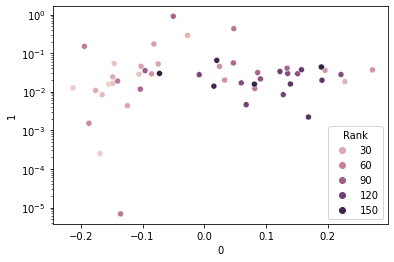

In [50]:
pca = PCA(n_components=2)
result = pca.fit_transform(merged[dept_cols])

result = pd.DataFrame(result)
result['Rank'] = merged['Rank'].values
sns.scatterplot(data=result, x=0, y=1, hue='Rank')
plt.yscale('log')
print(pca.explained_variance_)

In [51]:
from sklearn.linear_model import LinearRegression

In [52]:
clf = LinearRegression()
clf.fit(merged[dept_cols], merged['Rank'])

LinearRegression()

In [65]:
clf.coef_

array([-1.38022612e+04, -1.45476487e+04, -1.42090688e+04, -1.49942116e+04,
       -1.44815631e+04, -1.56432709e+04, -1.47752159e+04,  5.17502485e-10,
       -1.43900236e+04, -1.45262623e+04, -1.55886312e+04, -1.47974463e+04,
       -1.44363474e+04, -1.50463728e+04, -1.45255670e+04, -1.45338309e+04,
       -6.54836185e-11, -1.44254994e+04, -1.47910740e+04, -1.45519152e-11,
       -1.45130494e+04, -1.44035814e+04, -1.42053886e+04, -1.44476932e+04,
       -1.46170456e+04, -9.09494702e-12, -1.42597403e+04, -1.43906511e+04,
       -1.41384546e+04, -1.46472249e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.31406296e+04, -1.44508238e+04, -1.46171444e+04,
       -1.44252943e+04, -1.44288800e+04])

In [61]:
merged[dept_cols].columns[clf.coef_.argsort()]

Index(['PCIP10', 'PCIP15', 'PCIP22', 'PCIP05', 'PCIP16', 'PCIP27', 'PCIP11',
       'PCIP45', 'PCIP51', 'PCIP40', 'PCIP03', 'PCIP24', 'PCIP14', 'PCIP23',
       'PCIP30', 'PCIP09', 'PCIP50', 'PCIP39', 'PCIP19', 'PCIP54', 'PCIP26',
       'PCIP52', 'PCIP31', 'PCIP43', 'PCIP13', 'PCIP42', 'PCIP04', 'PCIP38',
       'PCIP44', 'PCIP01', 'PCIP49', 'PCIP25', 'PCIP29', 'PCIP41', 'PCIP46',
       'PCIP47', 'PCIP48', 'PCIP12'],
      dtype='object')

In [70]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

In [72]:
result = pd.DataFrame(squareform(pdist(merged[dept_cols])))

In [73]:
result.columns = merged.index
result.index = merged.index

In [77]:
result.loc['Furman University'].sort_values()[:20]

INSTNM
Furman University            0.000000
Gustavus Adolphus College    0.140416
Wheaton College              0.146428
Wheaton College              0.146428
Austin College               0.156720
Saint Mary's College         0.158674
Saint Anselm College         0.159468
College of Saint Benedict    0.163825
Coe College                  0.176037
Denison University           0.176815
University of Puget Sound    0.177356
Luther College               0.177562
DePauw University            0.179409
Berea College                0.182151
Ripon College                0.184693
Goucher College              0.185973
Albion College               0.188070
Saint Vincent College        0.191359
Hope College                 0.192290
Randolph College             0.193131
Name: Furman University, dtype: float64

In [78]:
from sklearn.manifold import TSNE

In [85]:
tsne = TSNE()
reduced = pd.DataFrame(tsne.fit_transform(merged[dept_cols]))
reduced['Rank'] = merged['Rank'].values
reduced.index = merged.index

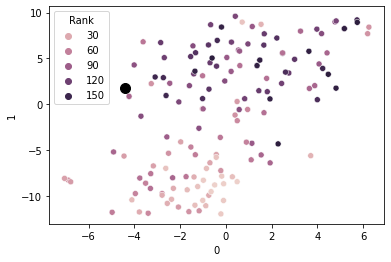

In [86]:
sns.scatterplot(data=reduced, x=0, y=1, hue='Rank')

furman = reduced.loc['Furman University']
plt.scatter(furman[0], furman[1], color='black', s=100)